# Setup

## Imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import arviz as az
import daft
import pystan
import seaborn as sns
import pandas as pd

from scipy.stats import gaussian_kde

import os
from collections import OrderedDict, defaultdict

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

## Stats utilities

In [3]:
def ComputeSymCI(samples, ci=0.9):
    """ Symmetric CI.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi - lo

In [4]:
def ComputeHPD(Samples, p=0.9):
    """ Find p-% HPD.
    """
    NewSamples = sort(Samples)
    n = len(Samples)
    m = int((1-n)*p)
    i = np.argmin(NewSamples[-m:] - NewSamples[:m])
    return (NewSamples[i], NewSamples[i+int(n*p)])

In [5]:
def ComputeHPD2(Samples, target=0, dp=0.00005, tol=0.001):
    """ Find HPD at target.
    """
    ps = np.arange(dp, 1, dp)
    for p in ps:
        try:
            lo, hi = ComputeHPD(Samples, p)
            lo_dist = lo - target
            hi_dist = hi - target
            if np.abs(hi_dist) < tol or np.abs(lo_dist) < tol:
                break
        except IndexError:
            pass
        except ValueError:
            pass
    if p == ps[-1]:
        # try with a worse tolerance
        return ComputeHPD2(Samples, target=0, dp=0.0005, tol=tol*2)
    return p, lo_dist, hi_dist

In [6]:
def HDI_from_MCMC(posterior_samples, credible_mass):
    import pymc3
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)

## Plotting utilities

In [7]:
def get_label(param):
    if param == 'dchiMinus2':
        l = r'$\delta\hat{\varphi}_{-2}$ {\fontsize{16pt}{3em}{ $(\times 20)$}'
    elif 'chi' in param:
        l =  param.replace('dchi', r'$\delta\hat{\varphi}_{') + '}$'
    elif 'alpha' in param:
        l = param.replace('dalpha', r'$\delta\hat{\alpha}_{') + '}$'
    else:
        l = param.replace('dbeta', r'$\delta\hat{\beta}_{') + '}$'
    return l 


def get_short_label(param):
    if 'chi' in param:
#         l = param.replace('Minus', '').replace('dchi', '')
        l =  param.replace('Minus', '-').replace('dchi', r'$\varphi_{') + '}$'
    elif 'alpha' in param:
        l = param.replace('dalpha', r'$\alpha_{') + '}$'
    else:
        l = param.replace('dbeta', r'$\beta_{') + '}$'
    return l 

In [8]:
wf_names = ['GW150914', 'GW151012','GW151226', 'GW170104', 'GW170608', 'GW170729','GW170809', 'GW170814', 'GW170818','GW170823']
# wf_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#6a3d9a','#ffff99']

def get_ls(event):
    if event in ['GW170608', 'GW151012', 'GW170814', 'GW170818', 'GW170823']:
        return '--'
    else:
        return '-'
    
# From O2 catalog paper
def get_event_colors():
    """Define colors for GW events.
    
    Let's use a customized version of HUSL, http://www.hsluv.org.
    As a starting point choose

    H = np.arange(11) * 360.0/12.
    S = 100
    L = 50
    
    The colors are too dark and greens are hard to distinguish. 
    Tweak the spacing in hue and increase luminosity to 60 ~ 70. 
    This is very similar to out of the box HUSL.
    Also provide a version where we desaturate every second color to S ~ 50 - 70.
    """
    colors_custom_full_S = ['#ff6c91', '#f77b00', '#c59700', '#9da500', '#55b300', '#00b47d', '#00b1a4', '#00aec2', '#00a7f0', '#9f8eff', '#ea65ff']
    colors_custom_desat = ['#ff6c91', '#d48d6f', '#c59700', '#9da355', '#55b300', '#58ae87', '#00b1a4', '#5ca9b8', '#00a7f0', '#9e94e2', '#ea65ff']

    event_list = ['GW170817', 'GW170608', 'GW151226', 'GW151012', 'GW170104', 'GW170814',
                  'GW170809', 'GW170818', 'GW150914', 'GW170823', 'GW170729']

    n = len(event_list)
    event_colors = defaultdict(str)
    colors = colors_custom_desat
    for k, v in zip(event_list, colors):
        event_colors[k] = v
    event_colors_F = dict(event_colors)
    del event_colors_F['GW170817']
    event_colors_P = event_colors
    
    return event_colors, event_colors_P, event_colors_F

_, color_dict, _ =  get_event_colors()

In [9]:
# make plots to fit the LaTex column size but rescale them for ease of display here
scale_factor = 4

fig_width_pt = scale_factor*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_ratio = (np.sqrt(5)-1.0)/2.0         # Plot aspect ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*fig_ratio       # height in inches
fig_size = [fig_width, fig_height]

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*8  # general
lfs = 0.9*fs  # legend
tfs0 = 0.8*fs  # ax0 ticks
tfs12 = 0.6*fs # ax1/2 ticks

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.size': fs,
    'font.serif': 'Computer Modern Roman',
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
}
matplotlib.rcParams.update(mplparams)

# sns.set(font_scale=1.5)
sns.axes_style("white")
sns.set_style("ticks", {'font.family': 'serif'})

# Intro

We want to see if we can (in a principled way, of course) stack "tests of GR" expressed as factors modifying a particular pN coefficient to extract information about or bound possible deviations.

In the absence of a model for how the deviations should behave as a function of the parameters of each system, a natural test is to look simultaneously for both

 * A shared "offset" such that the devaition parameter does not center around zero for the ensemble of systems
 * A measurable dispersion in the deviation parameter (with or without an offset) that suggests it is not identically zero for each system.
 
We can conduct such a search by fitting a hierarchical model (sometimes called a "population model," a "multi-level model," or an "extreme deconvolution") to the deviation parameters.  The simplest such model imposes a Gaussian population model with mean $\mu$ and s.d. $\sigma$; then the parameter $\mu$ fits the population mean deviation and $\sigma$ fits the population dispersion.  In GR, $\mu = \sigma = 0$; any measurably non-zero value indicates some deviation from GR in the population.

The model here is very similar to the classic "[eight schools](https://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/)" problem, but here we do not assume that the sampling distribution for the measurements (i.e. the likelihood function) is Gaussian, instead treating it as a KDE over samples drawn for each observation.

For more on hierarchical/multi-level modelling (aka "extreme deconvolution") see any good stats textbook or [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract), [Bovy, Hogg & Roweis (2010)](http://inspirehep.net/record/921489), or [Hogg, Myers & Bovy (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...725.2166H/abstract).

Assuming we have $i = 1, \ldots, N$ systems each with (GR) parameters $\theta_i$ and measured data $d_i$ and $\chi_i$ is the deviation parameter for each system (with $\chi_i = 0$ the GR prediciton), the graphical model we have is:

Choosing to use marginalized samples for $\chi_i$ alone is equivalent to integrating out the GR parameters according to the prior; to the extent that the prior does not match the true population, one may expect to eventually see "artificial" deviations from GR that correct the mis-match between population and prior.  This can be ameloriated by either (a) incorporating the tests of GR into a full population analysis that simultaneously fits the population for $\theta$ with enough degrees of freedom to match sufficiently well the true population to eliminate this bias or (b) replacing the default prior with one from a pure-GR population analysis.  (b) is easier, but has the defect that the correlations (if any) between the population and the modified GR parameters are not explored.

It is straightforward to just re-weight the posterior samples over $\chi_i$ by the ratio of the Gaussian with $\mu$-$\sigma$ to the prior used in the original analysis

The below Stan code implements this model.  Given posterior samples over $\chi_i$ for $N$ events, assumed to be drawn from a flat prior on $\chi_i$ (so their density is proportional to the likelihood), it samples from the posterior in $\mu$ and $\sigma$.  There is really no good reason to sample over a 2D posterior, except that it's quick and easy to write the Stan model and harder to write a debugged gridded posterior evaluation:

# Preprocessing

## Load

Load posteriors from disk:

In [10]:
CACHE = True
cache_path = 'cache/{}_{}.txt.gz'

In [11]:
all_events = ['150914', '151012', '151226', '170104', '170608', 
              '170729', '170809', '170814', '170818', '170823']

params = ['dchiMinus2']+ ['dchi%i' % n for n in range(5)] +\
         ['dchi5l', 'dchi6', 'dchi6l', 'dchi7']

params_ab = ['dalpha%i' % n for n in [2,3,4]] + ['dbeta%i' % n for n in [2,3]]

dipole_scale = 20

In [12]:
def load_cache(param):
    cache_exists = os.path.isfile(cache_path.format(param, 'mu')) and\
               os.path.isfile(cache_path.format(param, 'sigma'))
    if cache_exists:
        cache = {k: np.loadtxt(cache_path.format(param, k)) for k in ['mu', 'sigma']}
    else:
        cache = {}
    return cache

def save_cache(fits):
    for param, fit in fits.items():
        try:
            post = fit.extract(['mu', 'sigma'])
        except AttributeError:
            post = fit
        for k in ['mu', 'sigma']:
            np.savetxt(cache_path.format(param, k), post[k])
        print("Cached %s"%  param)

def load_data_fits(params):
    data = OrderedDict({})
    fits = OrderedDict({})
    for param in params:
        # attempt to load cache
        cache = load_cache(param) if CACHE else {}
        # load data if no cache found
        if not cache:
            chi_samples = OrderedDict({})
            for event in all_events:
                fname = "data/TIGER_posterior_samples/posterior_gw%s_%s.dat" % (event, param)
                if os.path.isfile(fname):
                    df = pd.read_csv(fname, sep='\t')
                    if param == 'dchiMinus2':
                        samples = df['dipolecoeff']*dipole_scale
                    else:
                        samples = df[param]
                    chi_samples[event] = samples
                else:
                    pass
            data[param] = chi_samples
        else:
            fits[param] = cache
    return data, fits

In [13]:
data, fits = load_data_fits(params + params_ab)

## Fit

In [14]:
if not all([p in fits for p in params+params_ab]):
    model = pystan.StanModel(file='hierGRtest.stan')
else:
    # no need to load model because fits cached
    model = None

In [15]:
# fit population
def fit_it(chi_samples, nobs, nsamp):
    samples = [cs[:nsamp] for cs in chi_samples[:nobs]]
    return model.sampling(data={'nobs': nobs, 'nsamp': nsamp, 'chis': samples}, iter=10000)

def fit_all(data, fits):
    failed = []
    for label, chi_samples_dict in data.items():
        if label not in fits:
            chi_samples = list(chi_samples_dict.values())
            no = len(chi_samples_dict)  # number of observations (events)
            nsamples = [len(s) for s in chi_samples]
            ns = min(min(nsamples), 5000)  # number of posterior samples
            if no > 0:
                fit = fit_it(chi_samples, no, ns)
                fits[label] = fit
            else:
                print("WARNING: no data for %s" % label)
                failed.append(label)
    if CACHE:
        save_cache(fits)
    return fits

In [16]:
fits = fit_all(data, fits)

Cached dchiMinus2
Cached dchi0
Cached dchi1
Cached dchi2
Cached dchi3
Cached dchi4
Cached dchi5l
Cached dchi6
Cached dchi6l
Cached dchi7
Cached dalpha2
Cached dalpha3
Cached dalpha4
Cached dbeta2
Cached dbeta3


In [17]:
# truth_lines = [('mu', {}, 0), ('sigma', {}, 0)]
# az.plot_trace(fit, lines=truth_lines)

### Posterior on the distribution

In [101]:
draws = OrderedDict({})
for i, param in enumerate(params+params_ab):
    mus = fits[param]['mu']
    sigmas = fits[param]['sigma']
    samples = []
    for mu,sigma in zip(mus, sigmas):
        samples.append(np.random.normal(mu, sigma))
    draws[param] = samples

In [230]:
params[0]

'dchiMinus2'

In [232]:
for param, samples in draws.items():
    if param == 'dchiMinus2':
        samples = np.array(samples)/dipole_scale
    print(param, ComputeSymCI(samples, ci=0.68))

dchiMinus2 0.009797656628421077
dchi0 0.2016238557667514
dchi1 0.5495485066046847
dchi2 0.4438324485514179
dchi3 0.34024162608483155
dchi4 1.5159969043365615
dchi5l 0.8650119535207266
dchi6 1.2372372002088925
dchi6l 2.3770535456433635
dchi7 1.9657115216881298
dalpha2 0.5835827677712956
dalpha3 1.601889861791768
dalpha4 0.7777327368896791
dbeta2 0.24540598861589585
dbeta3 0.29300527075032634


# Plots

## Posteriors

In [18]:
# # plot individual posteriors
# for label, chi_samples_dict in data.items():
# #     events = chi_samples_dict.keys()
#     fig, ax = plt.subplots(1)
#     for event, chi_samples in chi_samples_dict.items():
#         sns.kdeplot(chi_samples, alpha=1, label='GW'+event, clip=(-1, 1))
#     xlim(-1, 1)
#     xlabel(label)
#     ylabel(r'$p\left( d \mid %s \right)$' % label.replace('$',''))

## $\varphi$s

In [19]:
from bounded_1d_kde import Bounded_1d_kde

In [20]:
SIGMA_HIST = False

/Users/maxisi/custompy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/maxisi/custompy3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/maxisi/custompy3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/maxisi/custompy3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


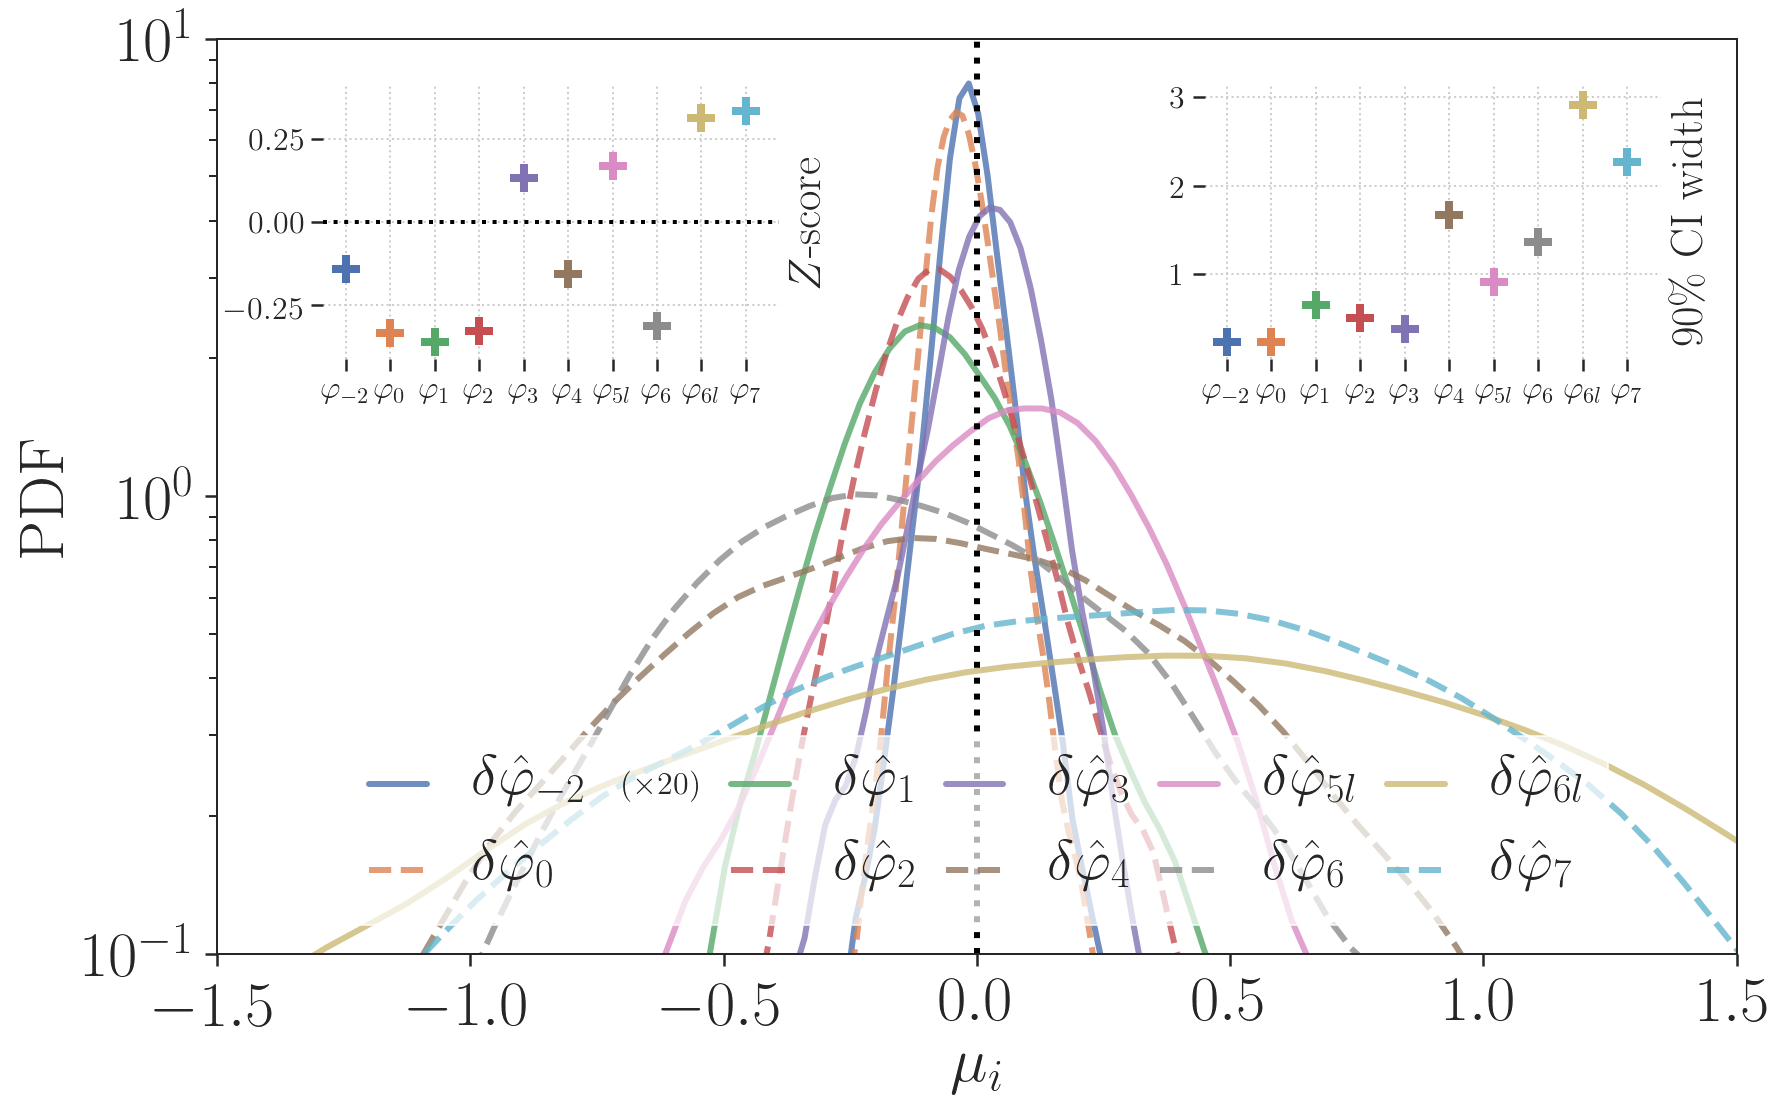

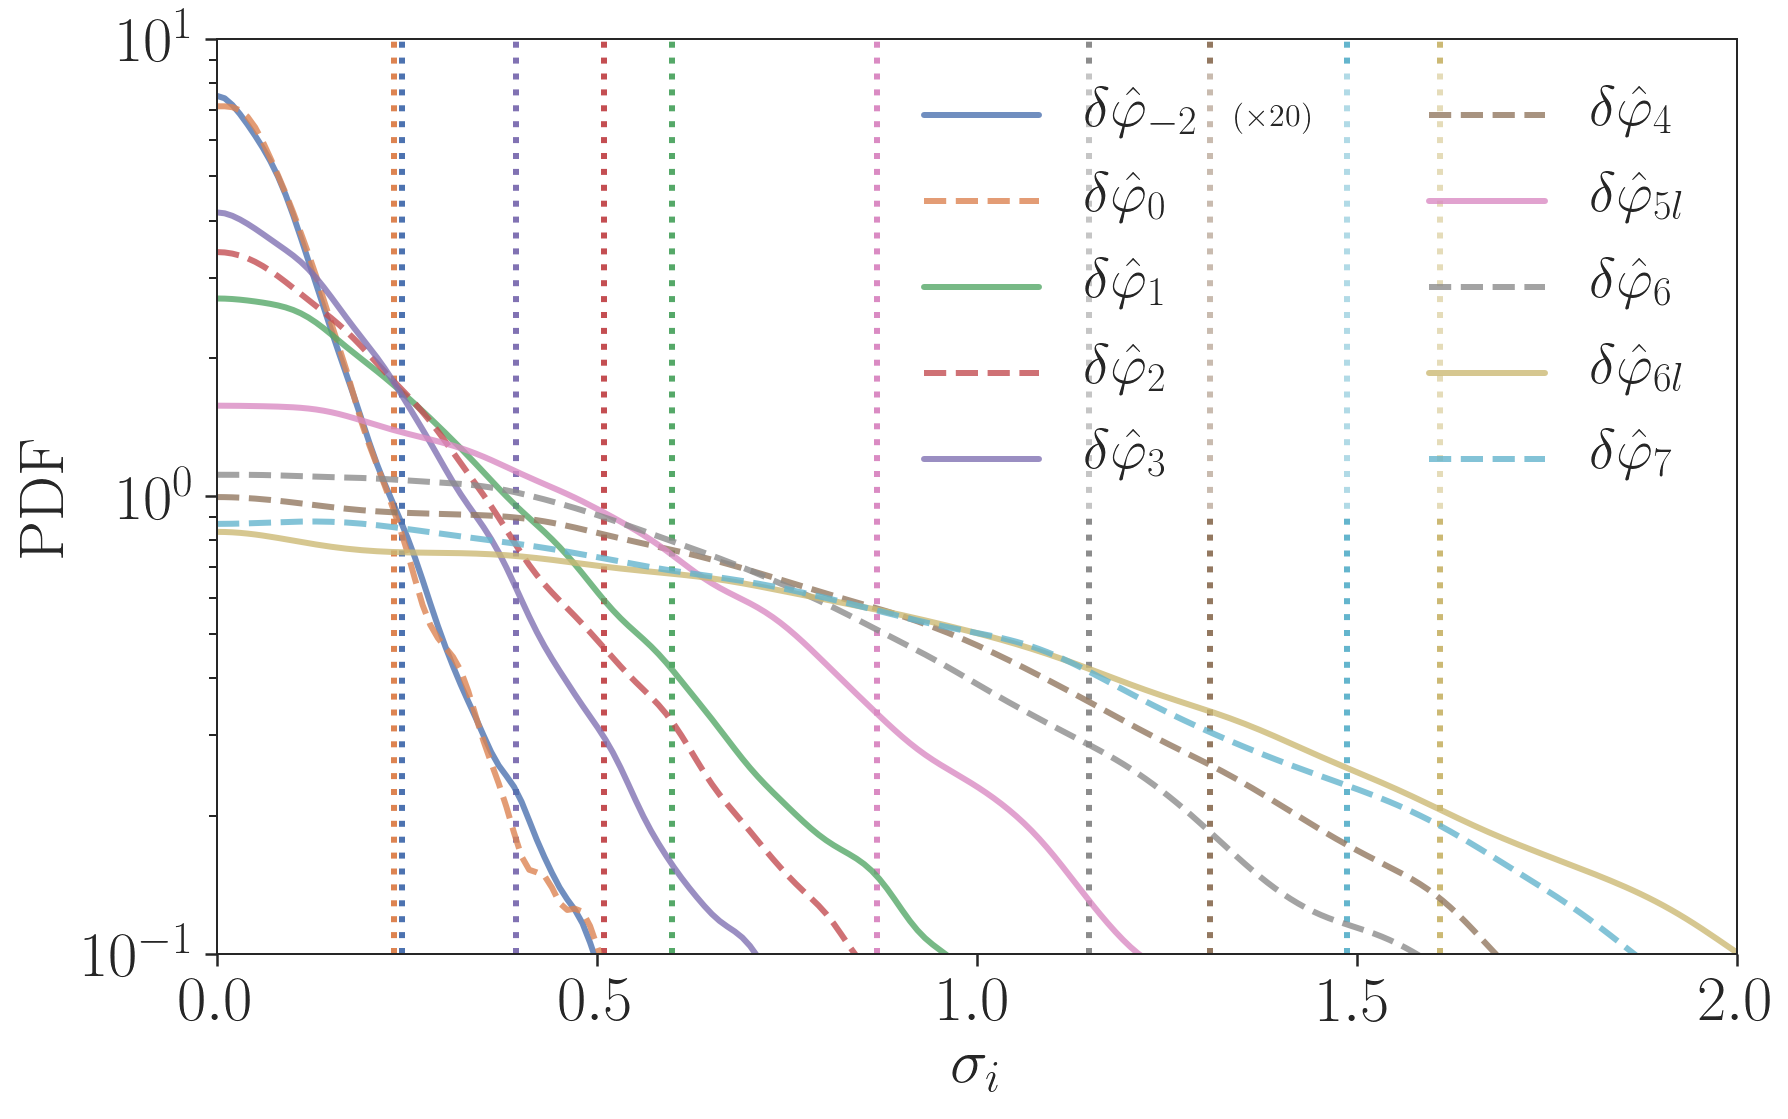

In [21]:
sns.set_palette('deep')

fig_mu, ax_mu = plt.subplots(1, figsize=fig_size)
fig_sigma, ax_sigma = plt.subplots(1, figsize=fig_size)

mu_inset_bounds = [0.07, 0.65, 0.3, 0.3]
mu_inset_bounds2 = [0.65, 0.65, 0.3, 0.3]
axin1_mu = ax_mu.inset_axes(mu_inset_bounds)
axin2_mu = ax_mu.inset_axes(mu_inset_bounds2)

sigma_inset_bounds = [0.4, 0.65, 0.3, 0.3]
sigma_inset_bounds2 = [0.4, 0.25, 0.3, 0.3]
axin1_sigma = None#ax_sigma.inset_axes(sigma_inset_bounds)
axin2_sigma = None#ax_sigma.inset_axes(sigma_inset_bounds2)

ls = '-'
lkwargs = {
    'lw': 3,
    'alpha': 0.8,
}

for i, param in enumerate(params):
    fit = fits[param]
    label = get_label(param)
    
    c = sns.color_palette()[i]
    lkwargs['c'] = c
    lkwargs['ls'] = ls
    
    # get mu, sigma
    post = fit

    # plot mu
    mu_CI90 = ComputeSymCI(post['mu'])
    zscore = np.mean(post['mu']) / np.std(post['mu'])
    sns.kdeplot(post['mu'], ax=ax_mu, label=label,  zorder=-100, **lkwargs)
    axin1_mu.scatter([i], [zscore], marker='+', s=200, linewidth=4)
    axin2_mu.scatter([i], [mu_CI90], marker='+', s=200, linewidth=4)
    
    # plot sigma
    p, lo, hi = ComputeHPD2(post['sigma'], 0)
    if axin1_sigma is not None:
        axin1_sigma.scatter([i], [p], marker='+', s=200, linewidth=4)
    sigma_90 = np.percentile(post['sigma'], 90)
    ax_sigma.axvline(sigma_90, ls=':', c=c, lw=3, zorder=-100)
    if SIGMA_HIST:
        ax_sigma.hist(post['sigma'], histtype='step', color=c, lw=lkwargs['lw'],
                      density=True, alpha=lkwargs['alpha'], ls=lkwargs['ls'],
                      label=label, bins=50)
    else:
        # get bounded KDE
        sigma_kde = Bounded_1d_kde(post['sigma'], xlow=0)
        sigma_vec = np.linspace(0, 5, 500)
        ax_sigma.plot(sigma_vec, sigma_kde.evaluate(sigma_vec),
                      label=label, **lkwargs)
#         sns.kdeplot(post['sigma'], ax=ax_sigma, clip=(0, 2),
#                     label=label,#+r', $\sigma^{90}=%.2f$' % sigma_90,
#                     **lkwargs)
    if axin2_sigma is not None:
        axin2_sigma.scatter([i], [sigma_90], marker='+', s=200, linewidth=4)
    
    if ls=='--':
        ls = '-'
    else:
        ls = '--'

xtlabels = [get_short_label(k) for k in params]
for axin in [axin1_mu, axin2_mu]:
    axin.tick_params('both', labelsize=fs*0.5)
    axin.set_xticks(range(len(xtlabels)))
    axin.set_xticklabels(xtlabels)
    axin.grid(True, ls=':')
    axin.yaxis.set_label_position("right")
    axin.set_frame_on(False)

import matplotlib.patches as patches
rect_kwargs = {
    'linewidth': 1,
    'edgecolor': 'w',
    'facecolor': 'w',
    'alpha': 0.8,
}
for bounds in [mu_inset_bounds, mu_inset_bounds2]:
    exp_x, exp_y = 0.2, 0.4
    ref = bounds[2]
    xy = [bounds[0] - ref*exp_x/2., bounds[1] - ref*exp_y/2.]
    rect = patches.Rectangle(xy, bounds[2]*(1+exp_x), bounds[3]*(1+exp_y),
                             transform=ax_mu.transAxes,
                             **rect_kwargs)
    ax_mu.add_patch(rect)

axin1_mu.set_ylabel(r'$Z$-score', fontsize=fs*0.7)
axin2_mu.set_ylabel(r'$90\%$ CI width', fontsize=fs*0.7)
axin1_mu.axhline(0, ls=':', c='k', lw=2)

if axin1_sigma is not None:
    axin1_sigma.set_ylabel(r'HPD $\sigma=0$', fontsize=fs*0.7)
    rect = patches.Rectangle(sigma_inset_bounds[:2], sigma_inset_bounds[2], sigma_inset_bounds[3],
                             transform=ax_sigma.transAxes, **rect_kwargs)
    ax_sigma.add_patch(rect)
    
if axin2_sigma is not None:
    # format
    axin2_sigma.tick_params('both', labelsize=fs*0.5)
    axin2_sigma.set_xticks(range(len(xtlabels)))
    axin2_sigma.grid(True, ls=':')
    axin2_sigma.yaxis.set_label_position("right")
    axin2_sigma.set_frame_on(False)
    # rectangle
    axin2_sigma.set_ylabel(r'$\sigma_{90}$', fontsize=fs*0.7)
    rect = patches.Rectangle(sigma_inset_bounds2[:2], sigma_inset_bounds2[2],
                             sigma_inset_bounds2[3], transform=ax_sigma.transAxes,
                             **rect_kwargs)
    ax_sigma.add_patch(rect)

ax_mu.axvline(0, ls=':', c='k', lw=3)
ax_mu.set_xlim(-1.5, 1.5)
ax_mu.set_ylabel(r'PDF', fontsize=fs)
ax_mu.set_xlabel(r'$\mu_i$', fontsize=fs)
# ax_mu.set_ylabel('PDF')
ax_mu.legend(fontsize=lfs, framealpha=0.7, loc='lower center', ncol=5, handlelength=1,
             edgecolor='w', columnspacing=0.5)
ax_mu.set_yscale('log')
ax_mu.set_ylim(1E-1, 10)

ax_sigma.set_xlim(0, 2)
ax_sigma.set_xlabel(r'$\sigma_i$', fontsize=fs)
ax_sigma.set_ylabel(r'PDF', fontsize=fs)
# ax_sigma.set_ylabel('PDF')
ax_sigma.legend(fontsize=lfs, framealpha=0.5, edgecolor='w', ncol=2)
ax_sigma.set_yscale('log')
ax_sigma.set_ylim(1E-1, 10)

plt.show(fig_mu)
plt.show(fig_sigma)

fig_mu.savefig('o2_tgr_chi_mu.pdf', bbox_inches='tight')
fig_sigma.savefig('o2_tgr_chi_sigma.pdf', bbox_inches='tight')

How many events were used per parameter?

In [22]:
for label, pdict in data.items():
    print("%s\t%i" % (label.replace('$',''), len(pdict)))

In [23]:
# az.plot_density(fit, var_names=['mu', 'sigma'])

### Distribution

/Users/maxisi/custompy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.5, 9.5, -1, 1)

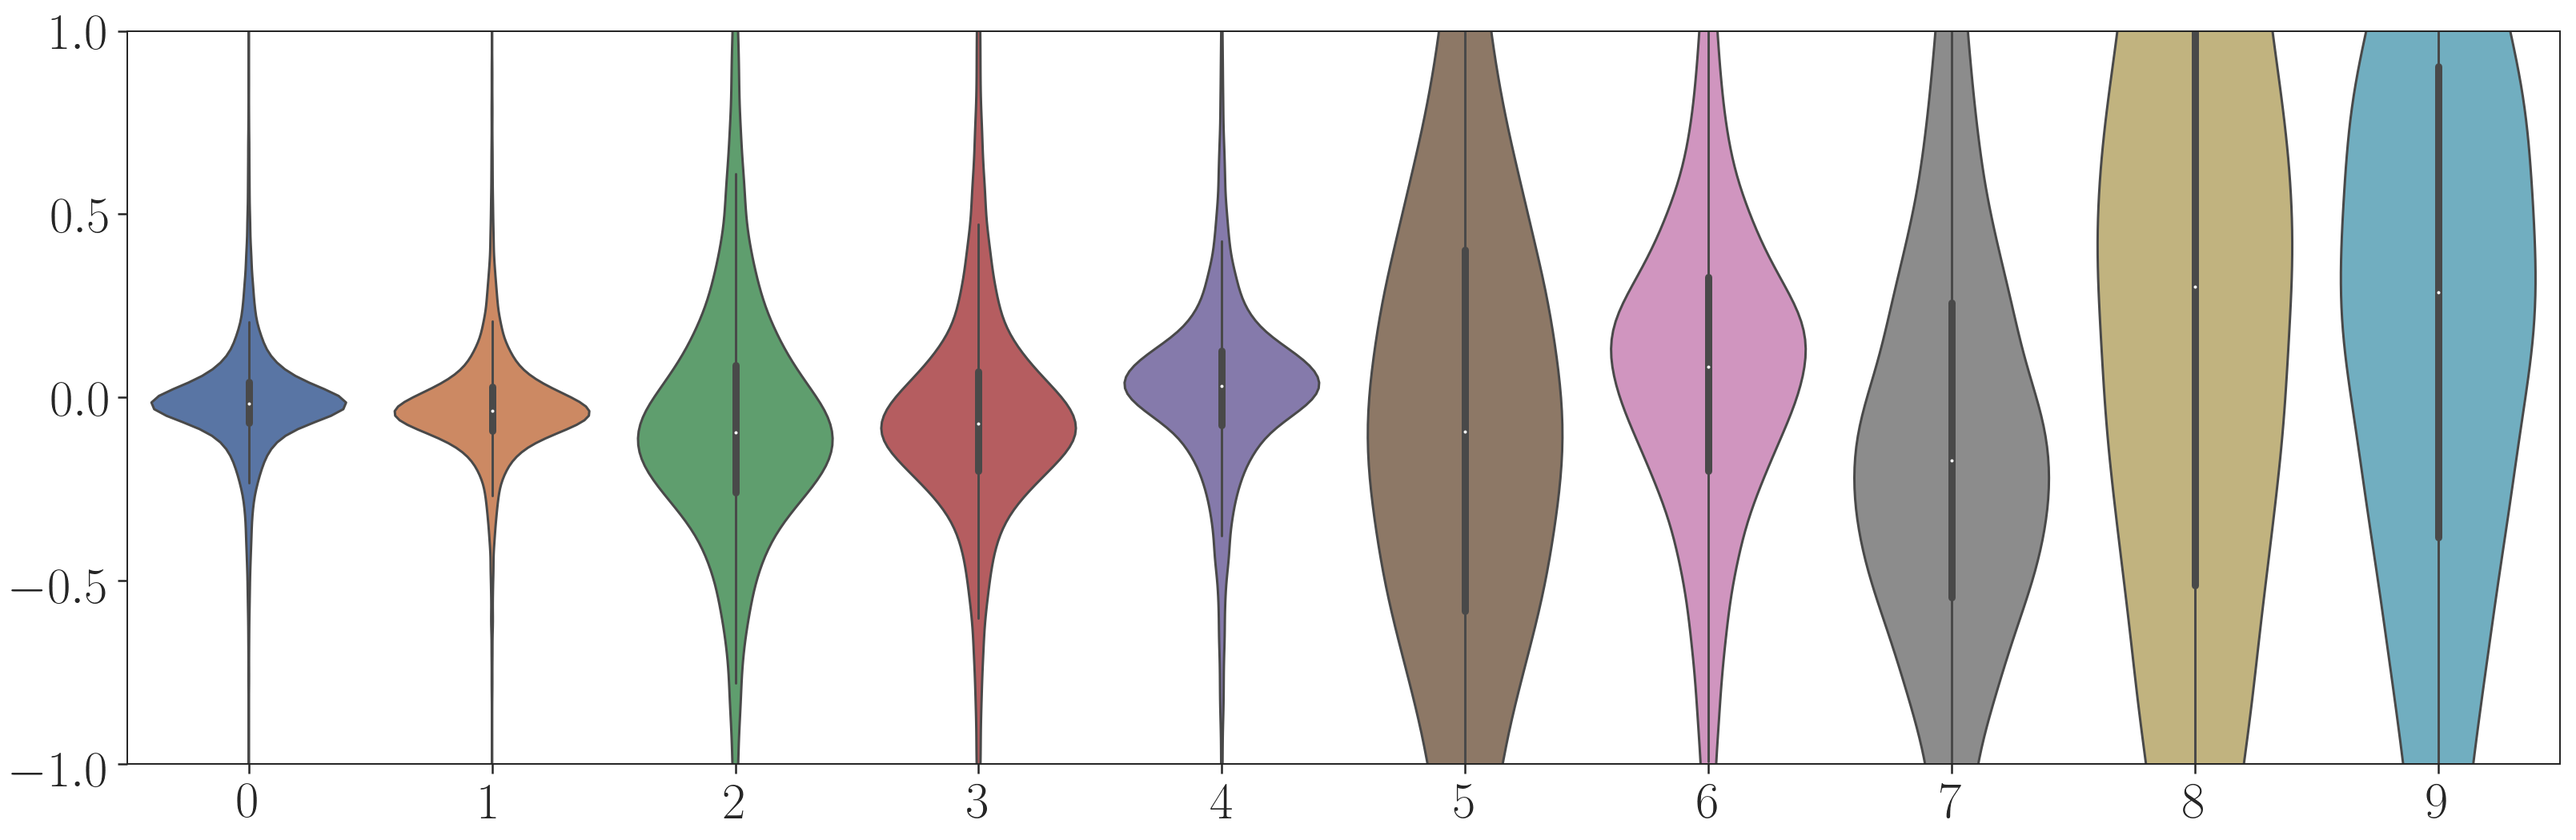

In [79]:
fig, ax = plt.subplots(1, figsize=(fig_width*2, fig_height))
sns.violinplot(data=list(draws.values()), ax=ax, scale='width', gridsize=500)
axis(ymin=-1, ymax=1)

### Individual plots

AttributeError: 'dict' object has no attribute 'extract'

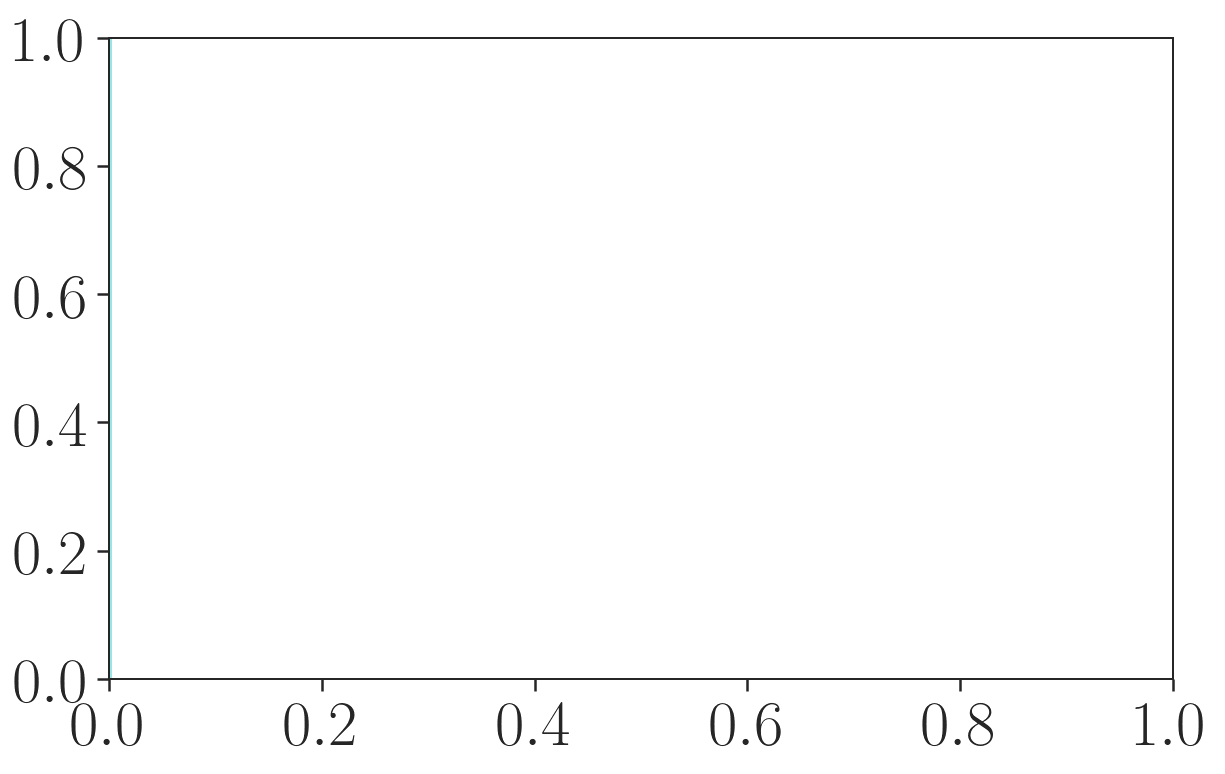

In [24]:
# sns.set_palette('deep')

# ls = '-'
# for i, (label, fit) in enumerate(fits.items()):
#     fig_mu, ax_mu = plt.subplots(1, figsize=(0.7*fig_size[0],0.7*fig_size[1]))
#     ax_mu.axvline(0, ls='-', c='c', lw=3, alpha=0.4)
# #     fig_sigma, ax_sigma = plt.subplots(1, figsize=fig_size)
#     c = sns.color_palette()[i]
#     lkwargs = {
#         'c': c,
#         'lw': 3,
#         'ls': ls,
#         'alpha': 0.8,
#     }
#     # get mu, sigma
#     post = fit.extract(['mu', 'sigma'])
    
#     # plot mu
#     p, lo, hi = ComputeHPD2(post['mu'], 0)
#     ax_mu.axvline(lo, ls=":", c=c, lw=2)
#     ax_mu.axvline(hi, ls=":", c=c, lw=2)
#     print(lo,hi)
    
#     mu_mean = np.mean(post['mu'])
#     ax_mu.axvline(mu_mean, ls="-", c=c, alpha=0.5, lw=2)
#     mu_median = np.percentile(post['mu'], 50)
#     ax_mu.axvline(mu_median, ls="-.", c=c, alpha=0.5, lw=2)
    
#     ax_mu.hist(post['mu'], histtype='step', bins=50, normed=True, color=c)
#     sns.kdeplot(post['mu'], ax=ax_mu, label=label, **lkwargs)
    
#     lo, hi = ComputeHPD(np.array(post['mu']), p=.1)
#     ax_mu.axvline(lo, ls="--", c='m')
#     ax_mu.axvline(hi, ls="--", c='m')
    
#     lo, hi = pymc3.stats.hpd(np.array(post['mu']), alpha=.9)
#     ax_mu.axvline(lo, ls=":", c='r', lw=2)
#     ax_mu.axvline(hi, ls=":", c='r', lw=2)

#     ax_mu.set_xlim(-0.5, 0.5)
#     ax_mu.set_ylabel(r'PDF', fontsize=fs)
#     ax_mu.set_xlabel(r'$\mu$', fontsize=fs)
#     # ax_mu.set_ylabel('PDF')
#     ax_mu.legend(fontsize=lfs, frameon=False)
#     # ax_mu.set_yscale('log')

#     plt.show(fig_mu)

In [ ]:
# ls = '-'
# for i, (label, fit) in enumerate(fits.items()):
#     fig_sigma, ax_sigma = plt.subplots(1, figsize=(0.7*fig_size[0],0.7*fig_size[1]))
#     c = sns.color_palette()[i]
#     lkwargs = {
#         'c': c,
#         'lw': 3,
#         'ls': ls,
#         'alpha': 0.8,
#     }
#     # get mu, sigma
#     post = fit.extract(['mu', 'sigma'])
#     samples = post['sigma']
    
#     ax_sigma.hist(samples, histtype='step', bins=50, normed=True, color=c)
#     sns.kdeplot(samples, ax=ax_sigma, bw=0.1,
#                 label=label,#+r', $\sigma^{90}=%.2f$' % sigma_90,
#                 **lkwargs)
    
#     sigma_kde = Bounded_1d_kde(samples, xlow=0)
#     sigma_vec = np.linspace(0, 5, 500)
#     ax_sigma.plot(sigma_vec, sigma_kde.evaluate(sigma_vec),
#                   label=label, marker='+', **lkwargs)
    
#     # plot sigma
#     p, lo, hi = ComputeHPD2(samples, 0)
#     axin1_sigma.scatter([i], [p], marker='+', s=200, linewidth=4)
#     ax_sigma.axvline(lo, ls=':', c='m', lw=2)
#     ax_sigma.axvline(hi, ls=':', c='m', lw=2)
#     print(p, lo, hi)
    
#     sigma_90 = np.percentile(samples, 90)
#     ax_sigma.axvline(sigma_90, ls='--', c=c, lw=3, zorder=-100)
    
#     ax_sigma.legend(fontsize=lfs, frameon=False)

#     plt.show(fig_sigma)

### Simulated samples

In [ ]:
# # simulated samples
# ls = '-'
# label = 'Gaussian'
# fig_mu, ax_mu = plt.subplots(1, figsize=(0.7*fig_size[0],0.7*fig_size[1]))
# ax_mu.axvline(0, ls='-', c='c', lw=3, alpha=0.4)
# #     fig_sigma, ax_sigma = plt.subplots(1, figsize=fig_size)
# c = sns.color_palette()[i]
# lkwargs = {
#     'c': c,
#     'lw': 3,
#     'ls': ls,
#     'alpha': 0.8,
# }
# # get mu, sigma
# post = {'mu': np.random.normal(0, 0.5, 1000000)}

# # # plot mu
# # p, lo, hi = ComputeHPD2(post['mu'], 0)
# # ax_mu.axvline(lo, ls=":", c=c, lw=2)
# # ax_mu.axvline(hi, ls=":", c=c, lw=2)
# # print(lo,hi)

# mu_mean = np.mean(post['mu'])
# ax_mu.axvline(mu_mean, ls="-", c=c, alpha=0.5, lw=2)
# mu_median = np.percentile(post['mu'], 50)
# ax_mu.axvline(mu_median, ls="-.", c=c, alpha=0.5, lw=2)

# ax_mu.hist(post['mu'], histtype='step', bins=50, normed=True, color=c)
# sns.kdeplot(post['mu'], ax=ax_mu, label=label, **lkwargs)

# p = .1

# # percentile
# ax_mu.axvline(np.percentile(post['mu'], 0.5*(1-p)*100), ls="-.", c='c', lw=2)
# ax_mu.axvline(np.percentile(post['mu'], (1-0.5*(1-p))*100), ls="-.", c='c', lw=2)

# # HPD custom
# lo, hi = ComputeHPD(np.array(post['mu']), p=p)
# ax_mu.axvline(lo, ls="--", c='m')
# ax_mu.axvline(hi, ls="--", c='m')

# # HPD pymc3
# lo, hi = pymc3.stats.hpd(np.array(post['mu']), alpha=1.-p)
# ax_mu.axvline(lo, ls=":", c='r', lw=2)
# ax_mu.axvline(hi, ls=":", c='r', lw=2)

# # HPD HDI_from_MCMC
# lo, hi = HDI_from_MCMC(np.array(post['mu']), p)
# ax_mu.axvline(lo, ls="-", c='orange', lw=4, alpha=0.5)
# ax_mu.axvline(hi, ls="-", c='orange', lw=4, alpha=0.5)


# ax_mu.set_xlim(-1, 1)
# ax_mu.set_ylabel(r'PDF', fontsize=fs)
# ax_mu.set_xlabel(r'$x$', fontsize=fs)
# # ax_mu.set_ylabel('PDF')
# ax_mu.legend(fontsize=lfs, frameon=False)
# # ax_mu.set_yscale('log')

# plt.show(fig_mu)

## $\alpha$ and $\beta$

/Users/maxisi/custompy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


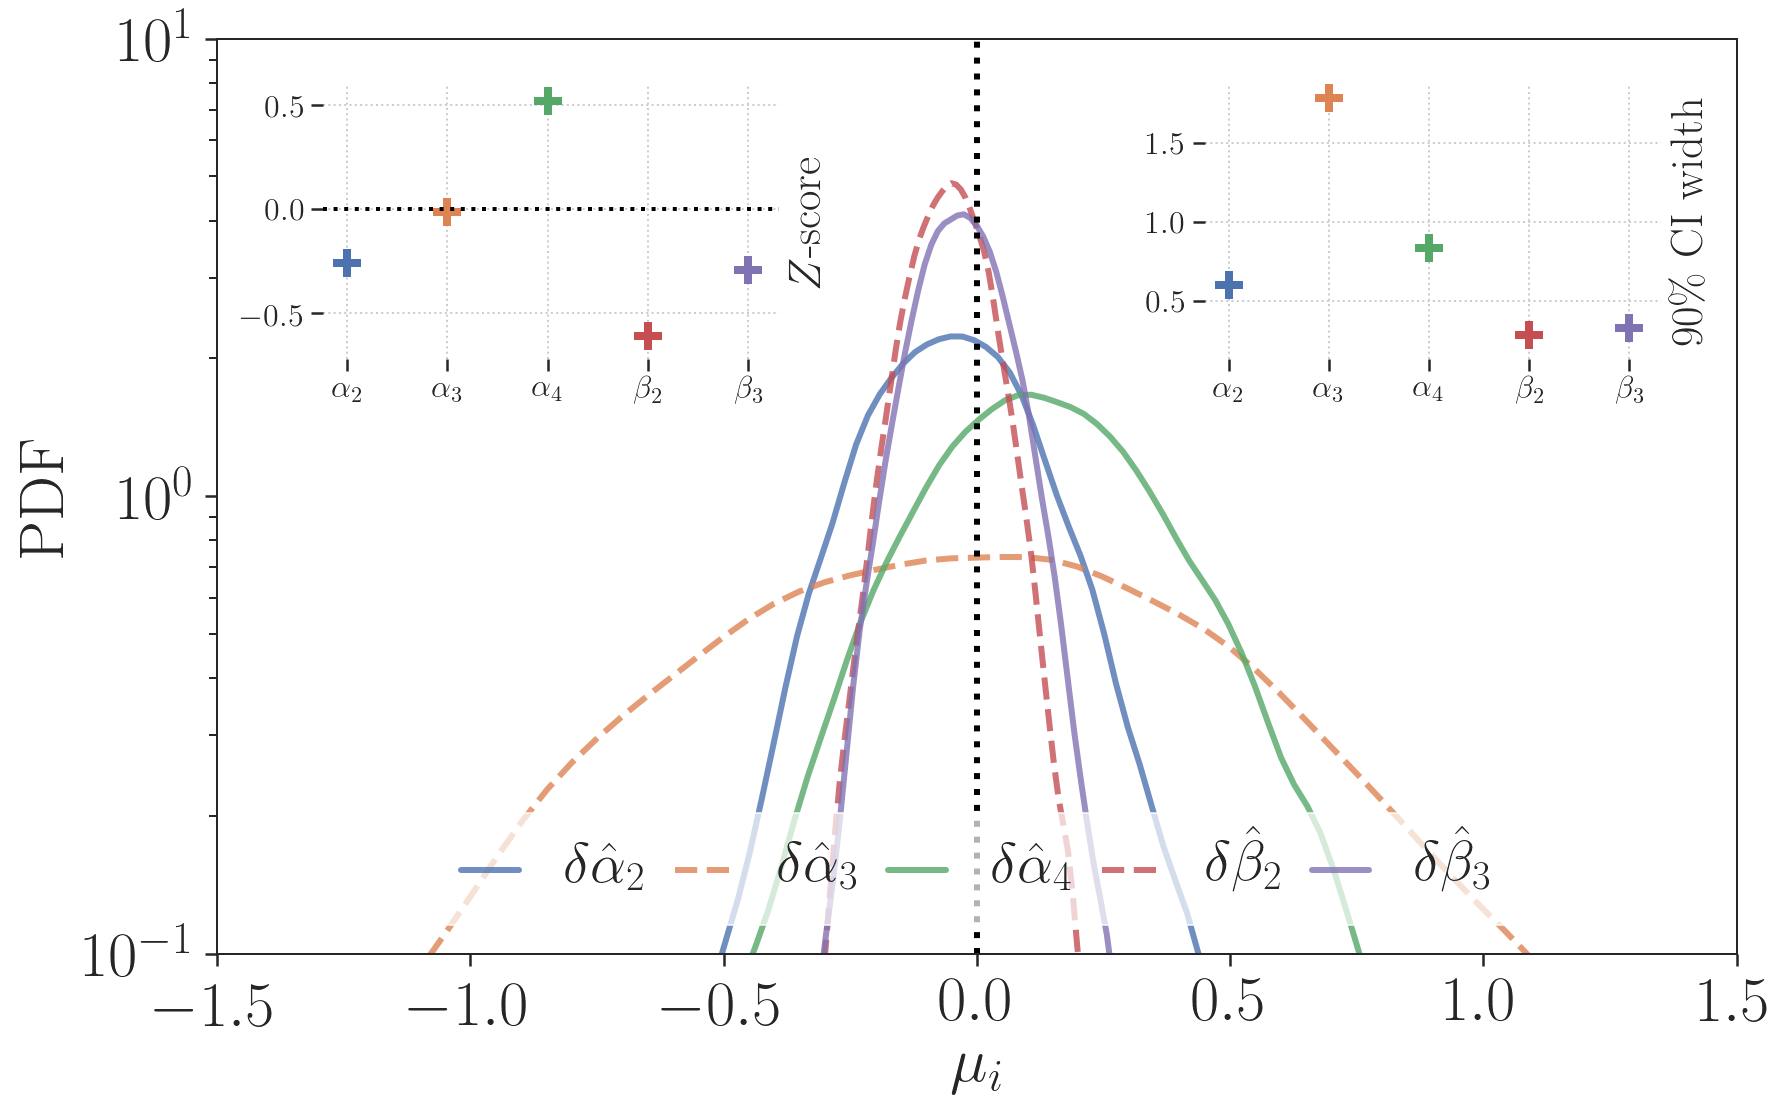

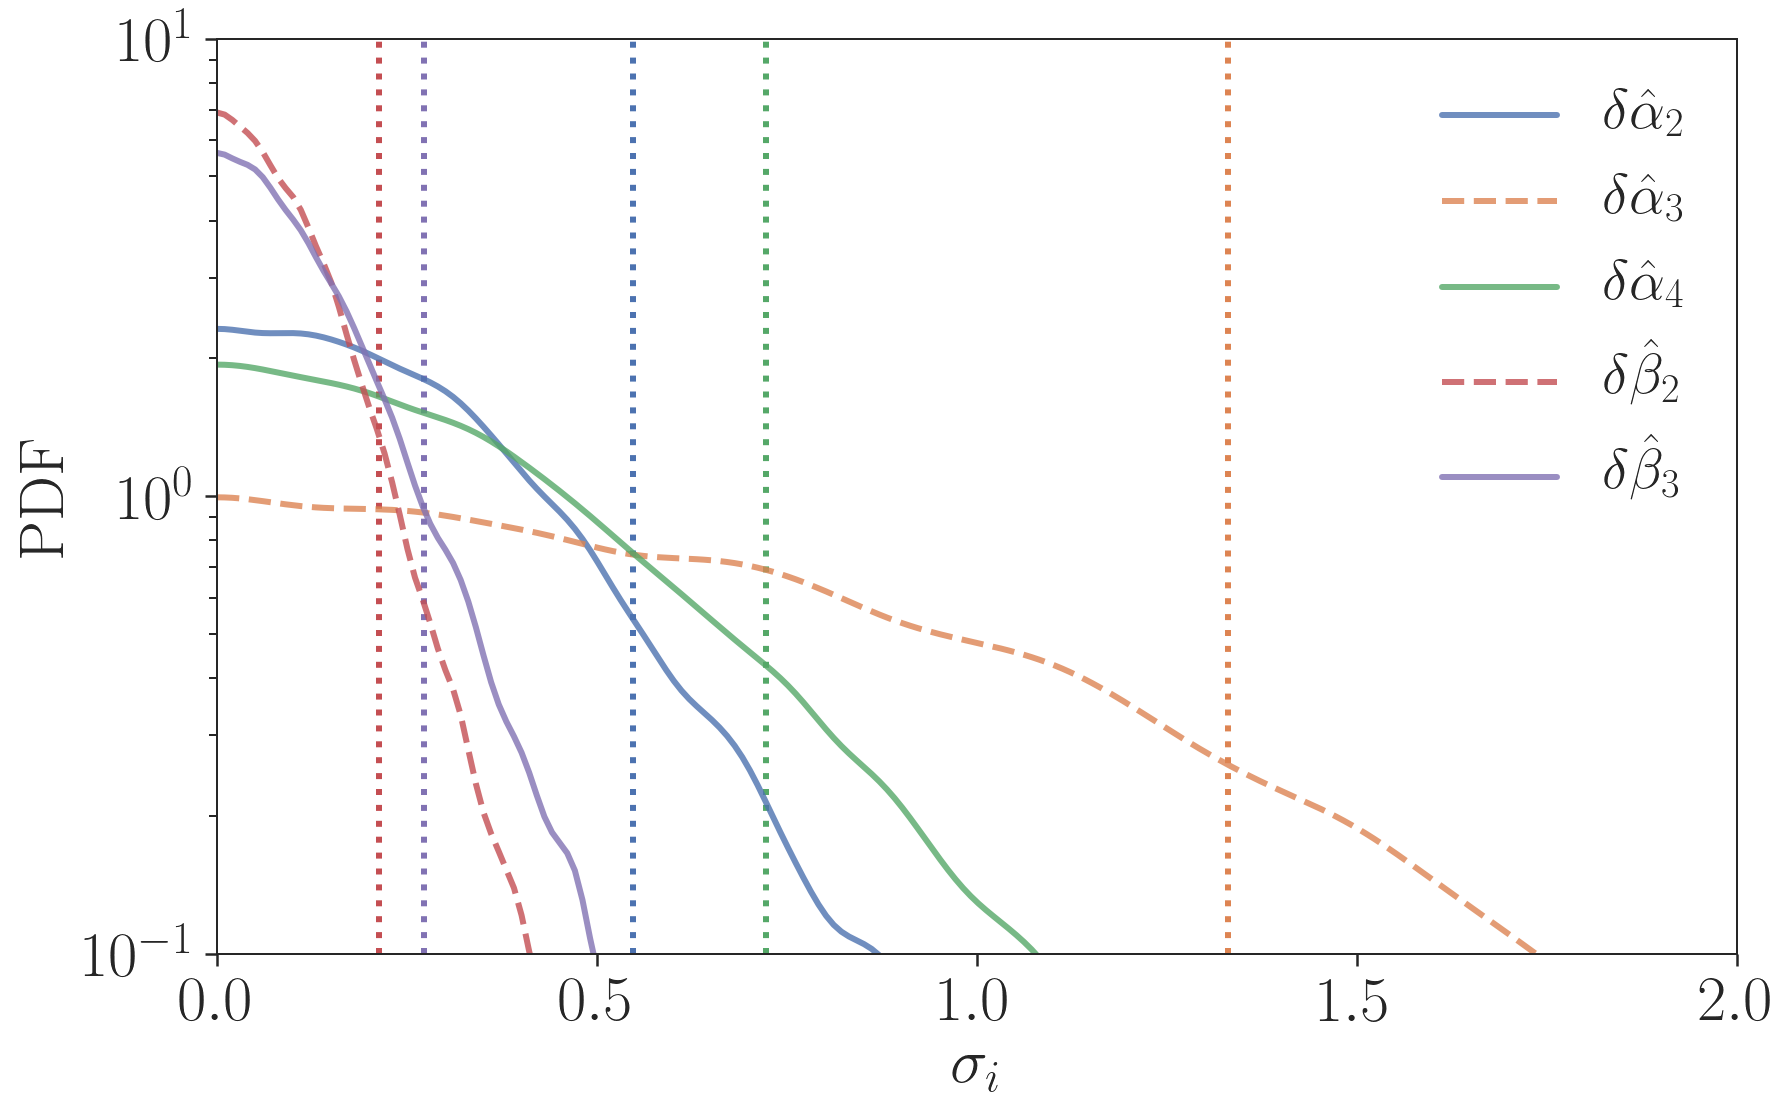

In [99]:
sns.set_palette('deep')

fig_mu, ax_mu = plt.subplots(1, figsize=fig_size)
fig_sigma, ax_sigma = plt.subplots(1, figsize=fig_size)

mu_inset_bounds = [0.07, 0.65, 0.3, 0.3]
mu_inset_bounds2 = [0.65, 0.65, 0.3, 0.3]
axin1_mu = ax_mu.inset_axes(mu_inset_bounds)
axin2_mu = ax_mu.inset_axes(mu_inset_bounds2)

sigma_inset_bounds = [0.4, 0.65, 0.3, 0.3]
sigma_inset_bounds2 = [0.4, 0.25, 0.3, 0.3]
axin1_sigma = None#ax_sigma.inset_axes(sigma_inset_bounds)
axin2_sigma = None#ax_sigma.inset_axes(sigma_inset_bounds2)

ls = '-'
lkwargs = {
    'lw': 3,
    'alpha': 0.8,
}

for i, param in enumerate([p for p in params_ab if p in fits]):
    label = get_label(param)
    fit = fits[param]
    
    c = sns.color_palette()[i]
    lkwargs.update({'c': c, 'ls': ls})
    
    # get mu, sigma
    post = fit

    # plot mu
    mu_CI90 = ComputeSymCI(post['mu'])
    zscore = np.mean(post['mu']) / np.std(post['mu'])
    sns.kdeplot(post['mu'], ax=ax_mu, label=label,  zorder=-100, **lkwargs)
    axin1_mu.scatter([i], [zscore], marker='+', s=200, linewidth=4)
    axin2_mu.scatter([i], [mu_CI90], marker='+', s=200, linewidth=4)
    
    # plot sigma
    p, lo, hi = ComputeHPD2(post['sigma'], 0)
    if axin1_sigma is not None:
        axin1_sigma.scatter([i], [p], marker='+', s=200, linewidth=4)
    sigma_90 = np.percentile(post['sigma'], 90)
    ax_sigma.axvline(sigma_90, ls=':', c=c, lw=3, zorder=-100)
    if SIGMA_HIST:
        ax_sigma.hist(post['sigma'], histtype='step', color=c, lw=lkwargs['lw'],
                      density=True, alpha=lkwargs['alpha'], ls=lkwargs['ls'],
                      label=label, bins=50)
    else:
        # get bounded KDE
        sigma_kde = Bounded_1d_kde(post['sigma'], xlow=0)
        sigma_vec = np.linspace(0, 5, 500)
        ax_sigma.plot(sigma_vec, sigma_kde.evaluate(sigma_vec),
                      label=label, **lkwargs)
#         sns.kdeplot(post['sigma'], ax=ax_sigma, clip=(0, 2),
#                     label=label,#+r', $\sigma^{90}=%.2f$' % sigma_90,
#                     **lkwargs)
    if axin2_sigma is not None:
        axin2_sigma.scatter([i], [sigma_90], marker='+', s=200, linewidth=4)
    
    if ls=='--':
        ls = '-'
    else:
        ls = '--'

# .strip(r'$\\delta').strip('}$')
xtlabels = [get_short_label(k) for k in params_ab]
for axin in [axin1_mu, axin2_mu]:
    axin.tick_params('both', labelsize=fs*0.5)
    axin.set_xticks(range(len(params_ab)))
    axin.set_xticklabels(xtlabels)
    axin.grid(True, ls=':')
    axin.yaxis.set_label_position("right")
    axin.set_frame_on(False)

import matplotlib.patches as patches
rect_kwargs = {
    'linewidth': 1,
    'edgecolor': 'w',
    'facecolor': 'w',
    'alpha': 0.8,
}
for bounds in [mu_inset_bounds, mu_inset_bounds2]:
    exp_x, exp_y = 0.2, 0.4
    ref = bounds[2]
    xy = [bounds[0] - ref*exp_x/2., bounds[1] - ref*exp_y/2.]
    rect = patches.Rectangle(xy, bounds[2]*(1+exp_x), bounds[3]*(1+exp_y),
                             transform=ax_mu.transAxes,
                             **rect_kwargs)
    ax_mu.add_patch(rect)

axin1_mu.set_ylabel(r'$Z$-score', fontsize=fs*0.7)
axin2_mu.set_ylabel(r'$90\%$ CI width', fontsize=fs*0.7)
axin1_mu.axhline(0, ls=':', c='k', lw=2)

if axin1_sigma is not None:
    axin1_sigma.set_ylabel(r'HPD $\sigma=0$', fontsize=fs*0.7)
    rect = patches.Rectangle(sigma_inset_bounds[:2], sigma_inset_bounds[2],
                             sigma_inset_bounds[3],
                             transform=ax_sigma.transAxes, **rect_kwargs)
    ax_sigma.add_patch(rect)
    
if axin2_sigma is not None:
    # format
    axin2_sigma.tick_params('both', labelsize=fs*0.5)
    axin2_sigma.set_xticks(range(len(fits)))
    axin2_sigma.grid(True, ls=':')
    axin2_sigma.yaxis.set_label_position("right")
    axin2_sigma.set_frame_on(False)
    # rectangle
    axin2_sigma.set_ylabel(r'$\sigma_{90}$', fontsize=fs*0.7)
    rect = patches.Rectangle(sigma_inset_bounds2[:2], sigma_inset_bounds2[2],
                             sigma_inset_bounds2[3], transform=ax_sigma.transAxes,
                             **rect_kwargs)
    ax_sigma.add_patch(rect)

ax_mu.axvline(0, ls=':', c='k', lw=3)
ax_mu.set_xlim(-1.5, 1.5)
ax_mu.set_ylabel(r'PDF', fontsize=fs)
ax_mu.set_xlabel(r'$\mu_i$', fontsize=fs)
# ax_mu.set_ylabel('PDF')
ax_mu.legend(fontsize=lfs, framealpha=0.7, loc='lower center', ncol=5, handlelength=1,
             edgecolor='w', columnspacing=0.5)
ax_mu.set_yscale('log')
ax_mu.set_ylim(1E-1, 10)

ax_sigma.set_xlim(0, 2)
ax_sigma.set_xlabel(r'$\sigma_i$', fontsize=fs)
ax_sigma.set_ylabel(r'PDF', fontsize=fs)
# ax_sigma.set_ylabel('PDF')
ax_sigma.legend(fontsize=lfs, framealpha=0.5, edgecolor='w', ncol=1)
ax_sigma.set_yscale('log')
ax_sigma.set_ylim(1E-1, 10)

plt.show(fig_mu)
plt.show(fig_sigma)

fig_mu.savefig('o2_tgr_ab_mu.pdf', bbox_inches='tight')
fig_sigma.savefig('o2_tgr_ab_sigma.pdf', bbox_inches='tight')

# Stats

In [25]:
# find lowest error in mu
mu_min_sig = np.inf
mu_min_mean = 0
mu_min_key = ''
for param, post in fits.items():
    if param == 'dchiMinus2':
        vals = post['mu'] / dipole_scale
    else:
        vals = post['mu']
    mu_sig = np.std(vals)
    if mu_sig < mu_min_sig:
        mu_min_sig = mu_sig
        mu_min_mean = np.mean(vals)
        mu_min_key = param

print(mu_min_key, mu_min_mean, mu_min_sig)

dchiMinus2 -0.0006217483422271581 0.0044571725445389735


In [ ]:
# The inferred population distribution for \delta\phi parameter given population to date.
# If GR is correct this should be a delta
# This is our inference for the distribution of allowed deviations from GR.

# Paper plots

In [235]:
ylabel = r'${\rm d}\, N/ {\rm d}\, (\delta \hat{p}_i$)'

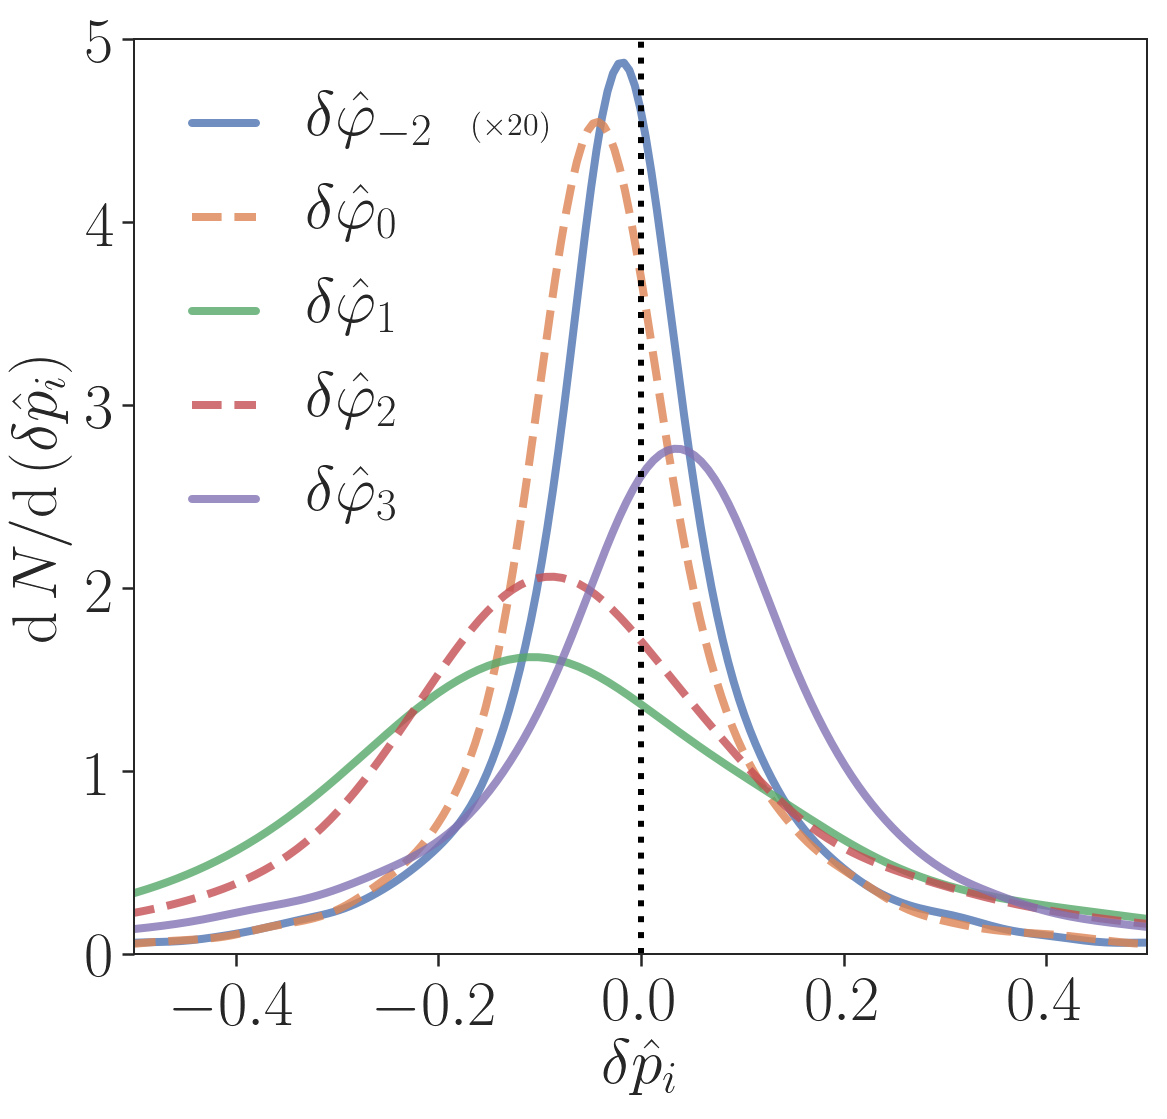

In [236]:
fig, ax = plt.subplots(1, figsize=(fig_width*(2/3.), fig_height))

sns.set_palette('deep')

ls = '-'
lkwargs = {
    'lw': 4,
    'alpha': 0.8,
}

for i,param in enumerate(params[:5]):
    mus = fits[param]['mu']
    sigmas = fits[param]['sigma']

    samples = draws[param]
        
    c = sns.color_palette()[i]
    lkwargs['c'] = c
    lkwargs['ls'] = ls

    k = gaussian_kde(samples)
    xs = linspace(min(samples), max(samples), 1000)
    ax.plot(xs, k(xs), label=get_label(param), **lkwargs)
    
    if ls=='--':
        ls = '-'
    else:
        ls = '--'

ax.axvline(0, ls=':', c='k', lw=3)

ax.legend(fontsize=fs, loc='upper left', ncol=1, handlelength=1, frameon=False)
ax.set_xlabel(r'$\delta\hat{p}_i$', fontsize=fs)
ax.set_ylabel(ylabel, fontsize=fs)

axis(xmin=-0.5, xmax=0.5, ymin=0, ymax=5)

fig.savefig('o2_tgr_phis1_pop.pdf')
# ax.set_yscale('log')
# ax.set_ylim(1E-1, 10)
plt.show(fig)

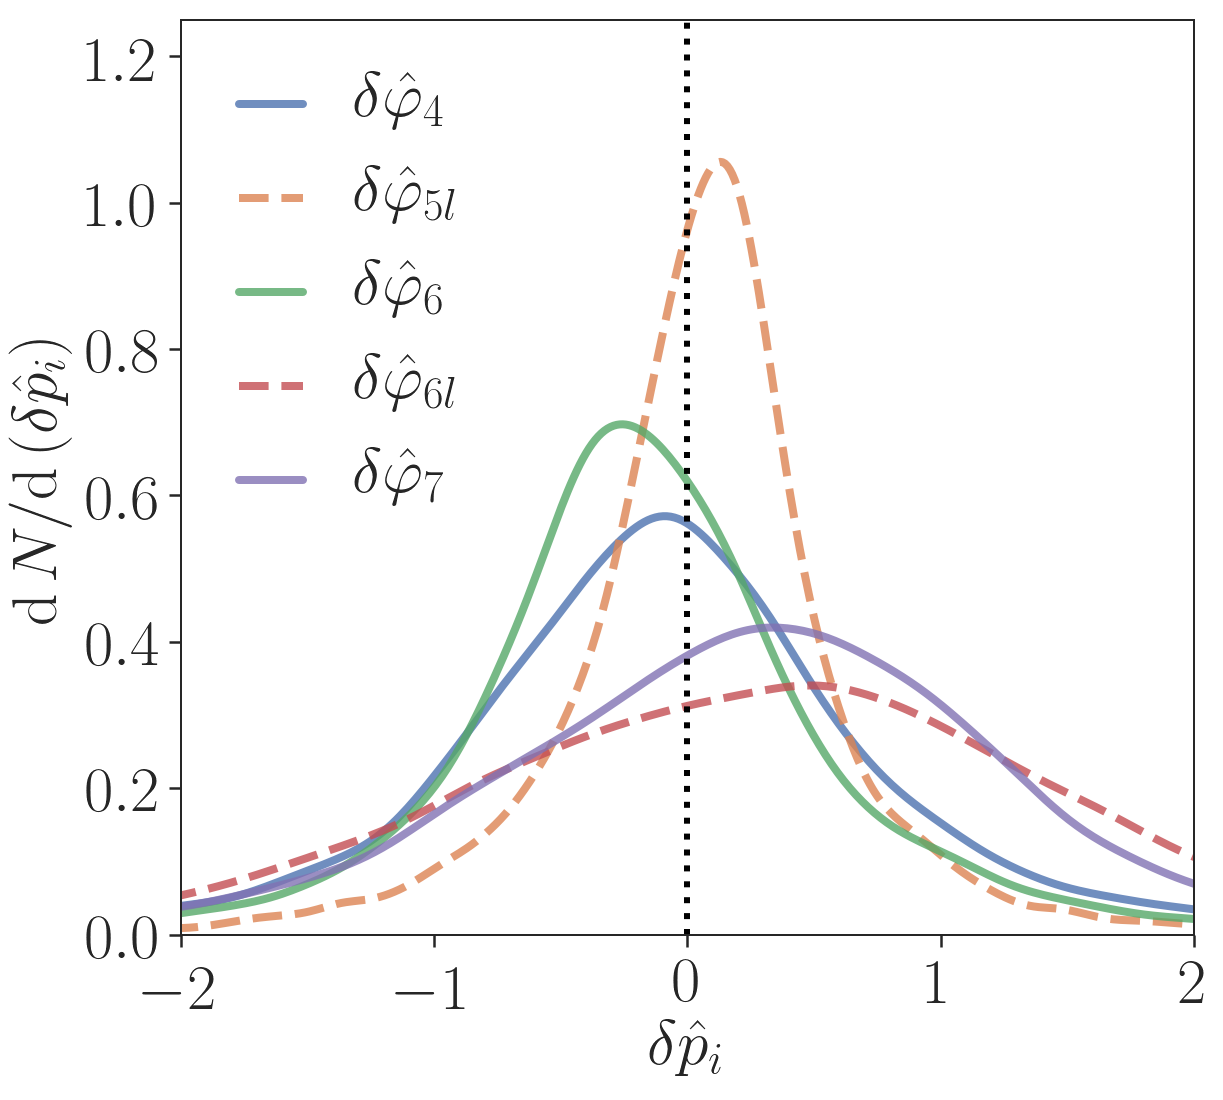

In [228]:
fig, ax = plt.subplots(1, figsize=(fig_width*(2/3.), fig_height))

sns.set_palette('deep')

ls = '-'
lkwargs = {
    'lw': 4,
    'alpha': 0.8,
}

# color_ids = range(5, 10)

for i,param in enumerate(params[5:]):
    mus = fits[param]['mu']
    sigmas = fits[param]['sigma']

    samples = draws[param]
        
    c = sns.color_palette()[i]#color_ids[i]]
    lkwargs['c'] = c
    lkwargs['ls'] = ls

    k = gaussian_kde(samples)
    xs = linspace(min(samples), max(samples), 1000)
    ax.plot(xs, k(xs), label=get_label(param), **lkwargs)
    
    if ls=='--':
        ls = '-'
    else:
        ls = '--'

ax.axvline(0, ls=':', c='k', lw=3)

ax.legend(fontsize=fs, loc='upper left', ncol=1, handlelength=1, frameon=False)
ax.set_xlabel(r'$\delta\hat{p}_i$', fontsize=fs)
ax.set_ylabel(ylabel, fontsize=fs)

axis(xmin=-2, xmax=2, ymin=0, ymax=1.25)

fig.savefig('o2_tgr_phis2_pop.pdf')
# ax.set_yscale('log')
# ax.set_ylim(1E-1, 10)
plt.show(fig)

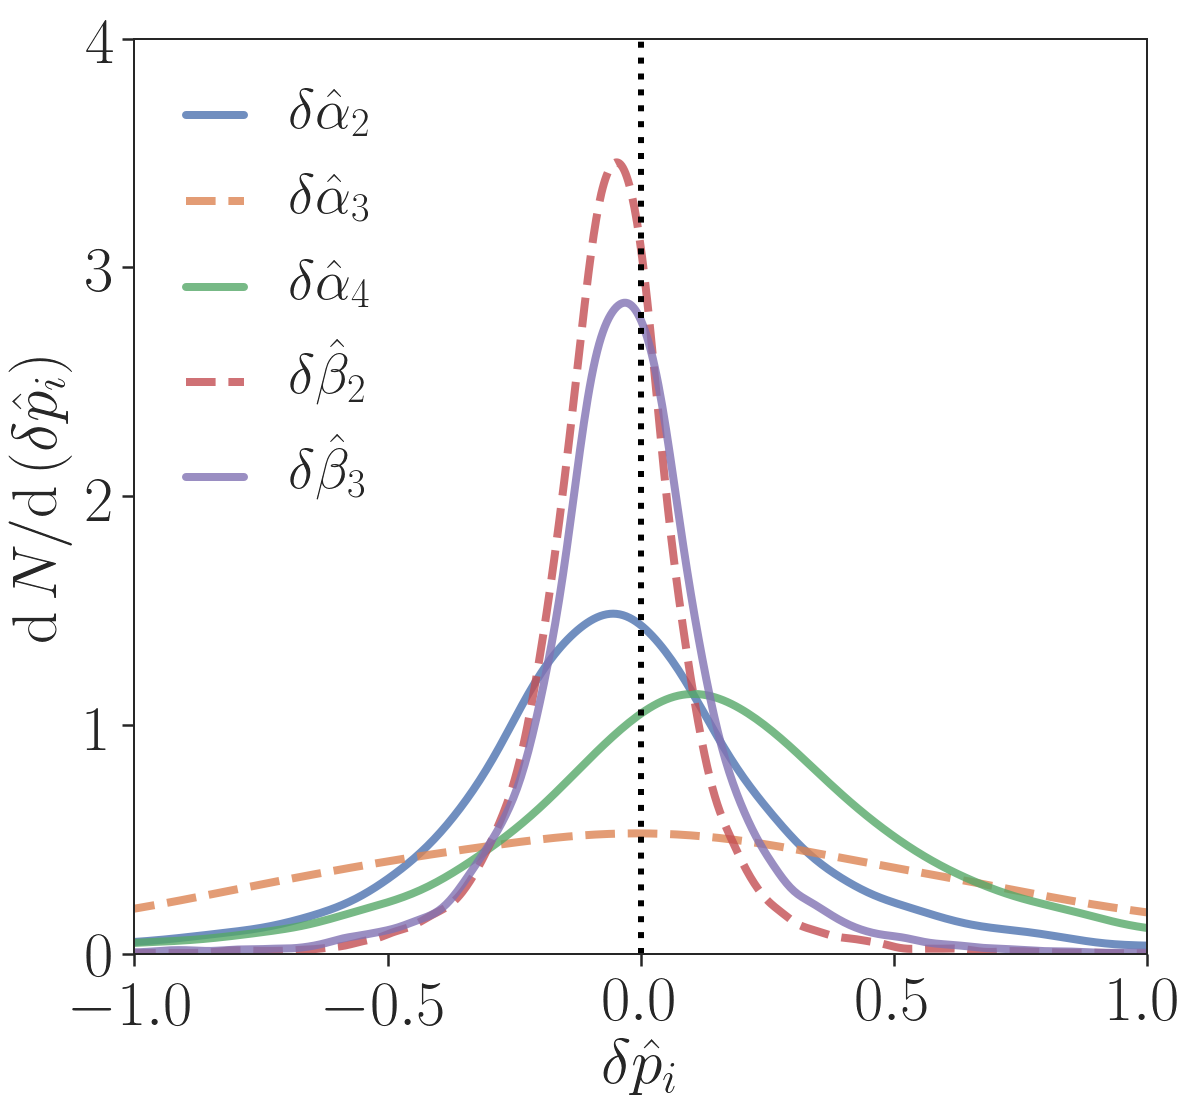

In [229]:
fig, ax = plt.subplots(1, figsize=(fig_width*(2/3.), fig_height))

sns.set_palette('deep')

ls = '-'
lkwargs = {
    'lw': 4,
    'alpha': 0.8,
}

for i, param in enumerate(params_ab):
    mus = fits[param]['mu']
    sigmas = fits[param]['sigma']

    samples = draws[param]
        
    c = sns.color_palette()[i]
    lkwargs['c'] = c
    lkwargs['ls'] = ls

    k = gaussian_kde(samples)
    xs = linspace(min(samples), max(samples), 1000)
    ax.plot(xs, k(xs), label=get_label(param), **lkwargs)
    
    if ls=='--':
        ls = '-'
    else:
        ls = '--'

ax.axvline(0, ls=':', c='k', lw=3)

ax.legend(fontsize=lfs, framealpha=0.7, loc='upper left', ncol=1, handlelength=1,
          edgecolor='w', columnspacing=0.5)
ax.set_xlabel(r'$\delta\hat{p}_i$', fontsize=fs)
ax.set_ylabel(ylabel, fontsize=fs)

axis(xmin=-1, xmax=1, ymin=0, ymax=4)
# ax.set_yscale('log')
# ax.set_ylim(1E-1, 10)

fig.savefig('o2_tgr_ab_pop.pdf')#, pad_inches=0.1, bbox_inches='tight')

plt.show(fig)

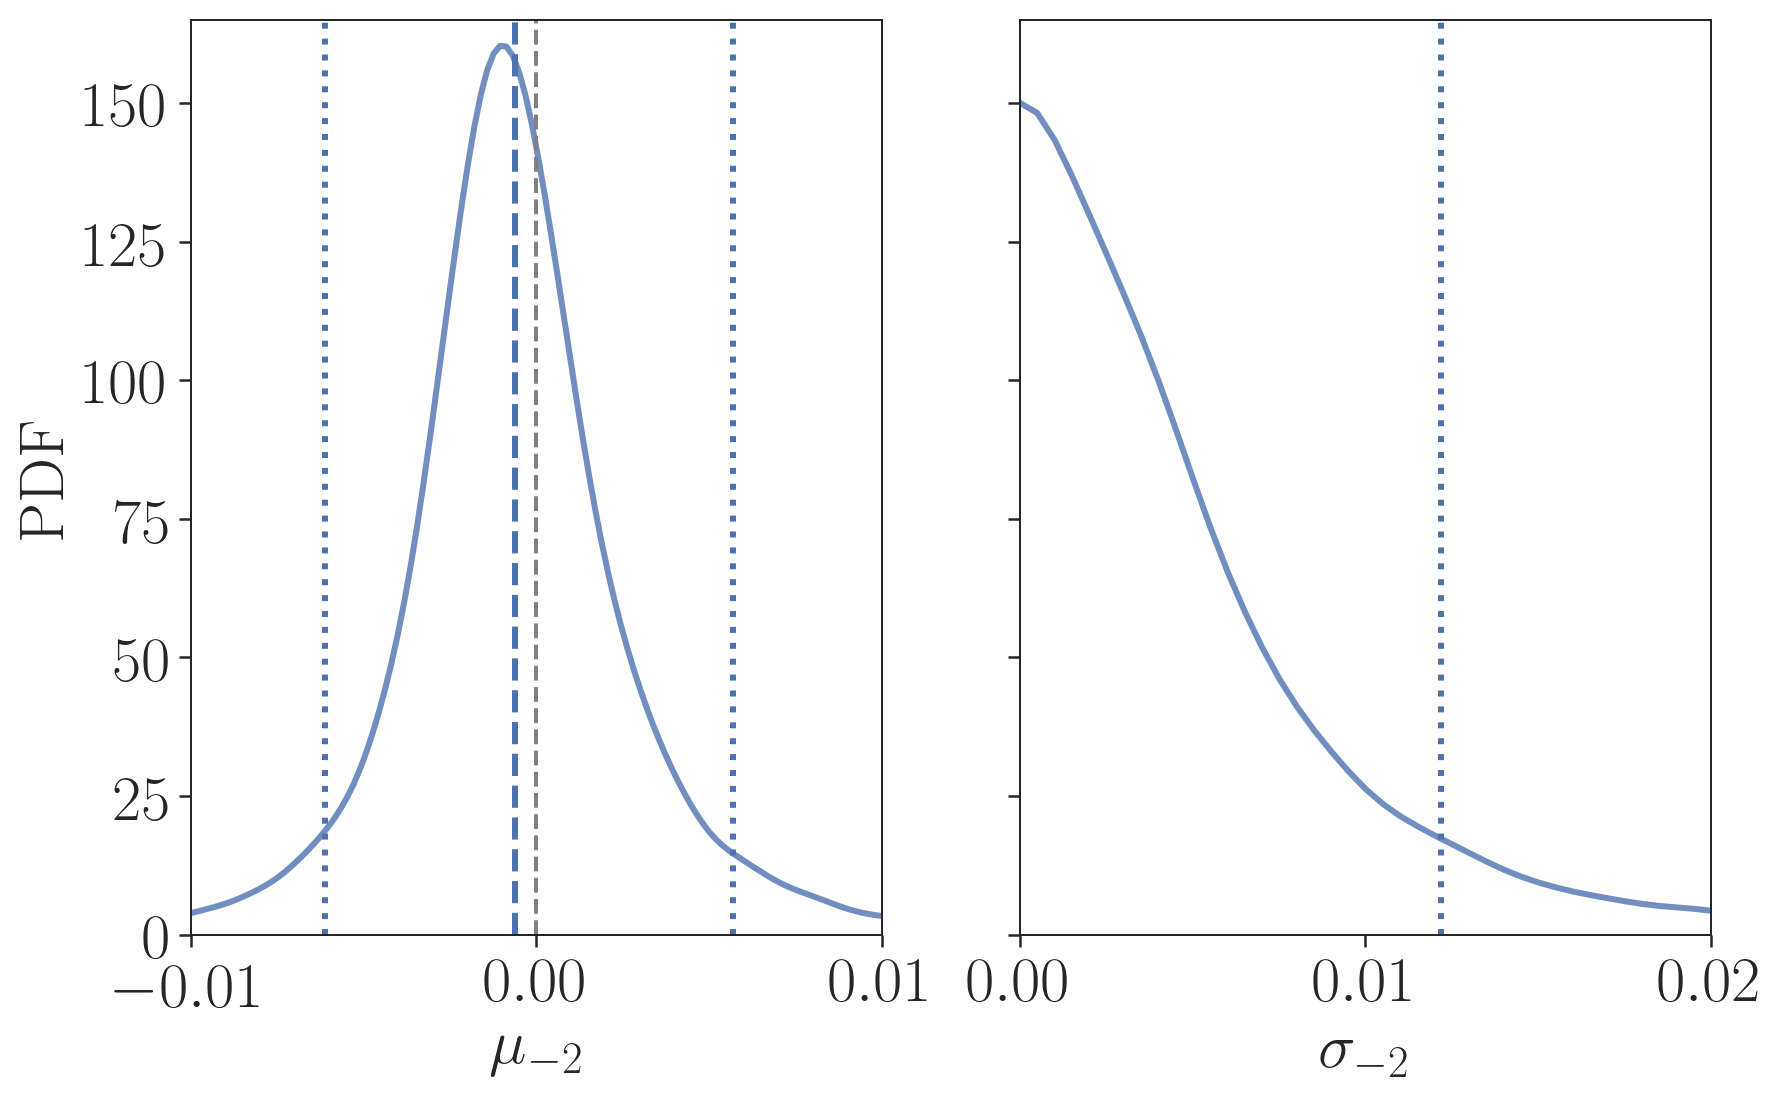

In [214]:
sns.set_palette('deep')

fig, (ax_mu, ax_sigma) = plt.subplots(1, 2, figsize=fig_size, sharey=True)
# fig.subplots_adjust(wspace=0.05)

lkwargs = {
    'lw': 3,
    'alpha': 0.8,
    'ls': '-',
    'c': sns.color_palette()[0]
}

param = 'dchiMinus2'
post = {k: v/dipole_scale for k,v in fit.items()}

fit = fits[param]
label = get_label(param)

# plot mu
mu_CI90 = ComputeSymCI(post['mu'])
zscore = np.mean(post['mu']) / np.std(post['mu'])
sns.kdeplot(post['mu'], ax=ax_mu, gridsize=500, zorder=-100, **lkwargs)

ax_mu.axvline(0, ls='--', c='gray', lw=2)

p = 0.90
ax_mu.axvline(np.percentile(post['mu'], 50*(1-p)), ls=':',
              c=lkwargs['c'], lw=3)
ax_mu.axvline(np.percentile(post['mu'], 100-50*(1-p)), ls=':',
              c=lkwargs['c'], lw=3)
ax_mu.axvline(np.mean(post['mu']), ls='--', c=lkwargs['c'], lw=3)

# plot sigma
sigma_90 = np.percentile(post['sigma'], 90)
ax_sigma.axvline(sigma_90, ls=':', c=c, lw=3, zorder=-100)

# get bounded KDE
sigma_kde = Bounded_1d_kde(post['sigma'], xlow=0)
sigma_vec = np.linspace(0, 5 / dipole_scale, 500)
ax_sigma.plot(sigma_vec, sigma_kde.evaluate(sigma_vec),
              label=label, **lkwargs)


ax_mu.set_xlim(-0.01, 0.01)
ax_mu.set_ylabel(r'PDF', fontsize=fs)
ax_mu.set_xlabel(r'$\mu_{-2}$', fontsize=fs)
ax_mu.set_ylim(0, 200)

ax_sigma.set_xlim(0, 0.02)
# ax_sigma.set_ylabel(r'PDF', fontsize=fs)
ax_sigma.set_xlabel(r'$\sigma_{-2}$', fontsize=fs)
ax_sigma.set_ylim(0, 165)

plt.show(fig)

fig.savefig('o2_tgr_%s_mu.pdf' % param, bbox_inches='tight')
# fig_sigma.savefig('o2_tgr_%s_sigma.pdf' % param, bbox_inches='tight')